In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<!--Empty Space for separating topics-->


In [3]:


IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

In [5]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [6]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [7]:
# The label for the fourth data element

train_dataset[3][1]

1

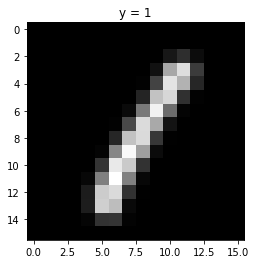

In [8]:
# The image for the fourth data element
show_data(train_dataset[3])


<h2 id="CNN">Build a Convolutional Neural Network Class</h2>


In [9]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2) # Output is 16 * 16
        self.maxpool1=nn.MaxPool2d(kernel_size=2) # Output is 8 * 8

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2) # Output is 8 * 8
        self.maxpool2=nn.MaxPool2d(kernel_size=2) # Output is 4 * 4
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out2 = out1.view(out1.size(0),-1)
        out3 = self.fc1(out2)
        return z1, a1, z2, a2, out1, out2, out3

There are 16 output channels for the first layer, and 32 output channels for the second layer


In [10]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

In [11]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [12]:
# Train the model

n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss and accuracy on the validation data:


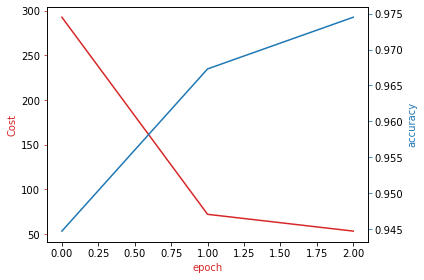

In [13]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

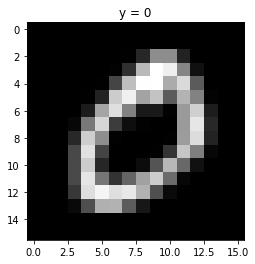

In [14]:
# Show the second image

show_data(train_dataset[1])

In [15]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

In [16]:
len(out)

7

In [17]:
z1, a1, z2, a2, out1, out2, out3 = out
print(z1.size())
print(a1.size())
print(z2.size())
print(a2.size())
print(out1.size())
print(out2.size())
print(out3.size())

torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 4, 4])
torch.Size([1, 512])
torch.Size([1, 10])


In [18]:
model.state_dict().keys()

odict_keys(['cnn1.weight', 'cnn1.bias', 'cnn2.weight', 'cnn2.bias', 'fc1.weight', 'fc1.bias'])

In [19]:
model.state_dict()['cnn1.weight'].size()

torch.Size([16, 1, 5, 5])

In [20]:
model.state_dict()['cnn2.weight'].size()

torch.Size([32, 16, 5, 5])

In [21]:
model.state_dict()['fc1.weight'].size()

torch.Size([10, 512])

Plot the first five mis-classified samples:


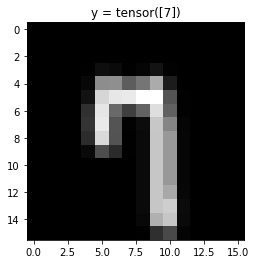

yhat:  tensor([9])


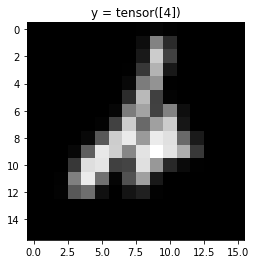

yhat:  tensor([2])


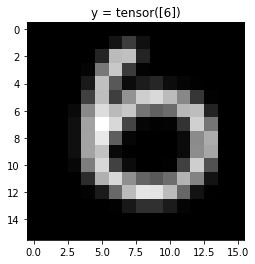

yhat:  tensor([0])


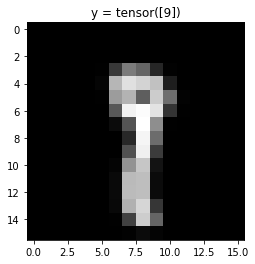

yhat:  tensor([1])


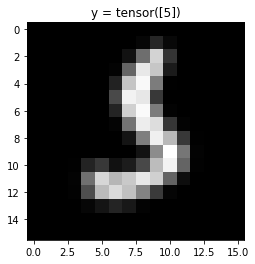

yhat:  tensor([3])


In [22]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  